## Transfomer Model 구현

## Dataset
네이버 영화 리뷰 데이터셋
https://github.com/e9t/nsmc

## References
 - https://arxiv.org/abs/1706.03762



# 라이브러리 설치

In [65]:
!pip install sentencepiece
!pip install wget

Imports

In [66]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from IPython.display import display
from tqdm import tqdm, tqdm_notebook, trange
import sentencepiece as spm
import wget
import datetime

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.onnx
import seaborn as sns
import openpyxl

## 네이버 영화 리뷰 데이터셋 다운로드

In [67]:
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
!head ratings_train.txt
!head ratings_test.txt

'ratings_train.txt'

## Google Sentencepiece를 활용해 Vocab 만들기

 - input: 입력 corpus
 - prefix: 저장할 모델 이름
 - vocab_size: vocab 개수 (기본 8,000에 스페셜 토큰 7개를 더해서 8,007개)
 - max_sentence_length: 문장의 최대 길이
 - pad_id, pad_piece: pad token id, 값
 - unk_id, unk_piece: unknown token id, 값
 - bos_id, bos_piece: begin of sentence token id, 값
 - eos_id, eos_piece: end of sequence token id, 값
 - user_defined_symbols: 사용자 정의 토큰

Sentencepiece 외에도 Mecab + Sentencepiece / Wordpiece 등을 이용.

자세한 내용은 아래 References 참조

## References
 - https://arxiv.org/abs/1706.03762


In [68]:
corpus = "ratings_train.txt"
prefix = "nsmc"
vocab_size = 8000
spm.SentencePieceTrainer.train(
    f"--input={corpus} --model_prefix={prefix} --vocab_size={vocab_size + 7}" + 
    " --model_type=bpe" +
    " --max_sentence_length=999999" + # 문장 최대 길이
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)
    " --user_defined_symbols=[SEP],[CLS],[MASK]") # 사용자 정의 토큰

Sentencepiece를 활용해 만든 Vocab 불러오기

In [69]:
# vocab loading
vocab_file = f"nsmc.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

## 네이버 영화 리뷰 데이터 전처리 함수

다운로드된 데이터를 vocab으로 미리 tokenize해서 json형태로 저장 해 놓습니다.

tokenize를 미리하지 않고 training시에 할 경우 처리시간이 매번 소요 되므로 이를 효과적으로 줄이기 위함 입니다.

In [70]:
""" train data 준비 """
def prepare_train(vocab, infile, outfile):
    df = pd.read_csv(infile, sep="\t", engine="python")
    with open(outfile, "w") as f:
        for index, row in df.iterrows():
            document = row["document"]
            if type(document) != str:
                continue
            instance = { "id": row["id"], "doc": vocab.encode_as_pieces(document), "label": row["label"] }
            f.write(json.dumps(instance))
            f.write("\n")

##아래 코드를 실행하면 전처리된 파일이 생성 됩니다.

- 학습데이터: ratings_train.json
- 평가데이터: ratings_test.json

In [71]:
prepare_train(vocab, "ratings_train.txt", "ratings_train.json")
prepare_train(vocab, "ratings_test.txt", "ratings_test.json")

Device GPU 사용

In [72]:

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cpu


TransFomer Model Config 입력

In [73]:
""" configuration json을 읽어들이는 class """
class Config(dict): 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [74]:
config = Config({
    "n_enc_vocab": len(vocab),
    "n_dec_vocab": len(vocab),
    "n_enc_seq": 256, 
    "n_dec_seq": 256, 
    "n_layer": 6,
    "d_hidn": 256,
    "i_pad": 0,
    "d_ff": 1024,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "layer_norm_epsilon": 1e-12
})
print(config)

{'n_enc_vocab': 8007, 'n_dec_vocab': 8007, 'n_enc_seq': 256, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


## Positional Encoding 함수

Position encoding값을 구하기 위한 함수는 아래와 같습니다.

각 position별 hidden index별 angle값을 구합니다. (줄: 8)

hidden 짝수 index의 angel값의 sin값을 합니다. (줄: 9)

hidden 홀수 index의 angel값의 cos값을 합니다. (줄: 10)

In [75]:
""" sinusoid position encoding """
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table

## Attention Padding Mask 함수

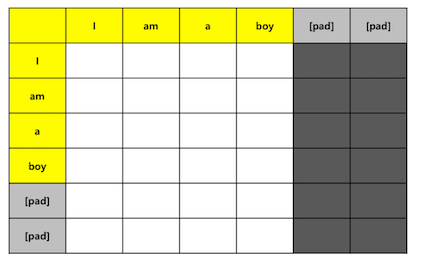

Attention을 구할 때 Padding 부분을 제외하기 위한 Mask를 구하는 함수 입니다.

K의 값 중에 Pad인 부분을 True로 변경 합니다. (나머지는 False) (줄: 5)

구해진 값의 크기를 Q-len, K-len 되도록 변경 합니다. (줄: 6)

In [76]:
""" attention pad mask """
def get_attn_pad_mask(seq_q, seq_k, i_pad):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(i_pad)
    pad_attn_mask = pad_attn_mask.unsqueeze(1).expand(batch_size, len_q, len_k)
    return pad_attn_mask

## Attention Decoder Mask 함수

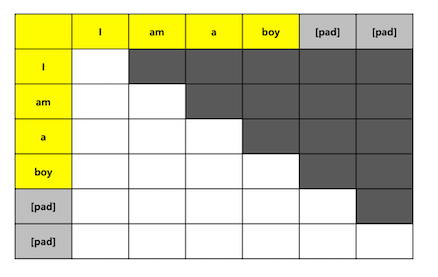


Decoder의 ‘Masked Multi Head Attention’에서 사용할 Mask를 구하는 함수 입니다. 

현재단어와 이전단어는 볼 수 있고 다음단어는 볼 수 없도록 Masking 합니다.

모든 값이 1인 Q-len, K-len 테이블을 생성 합니다. (줄: 3)

대각선을 기준으로 아래쪽을 0으로 만듭니다. (줄: 4)

In [77]:
""" attention decoder mask """
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    return subsequent_mask

## ScaledDotProductAttention
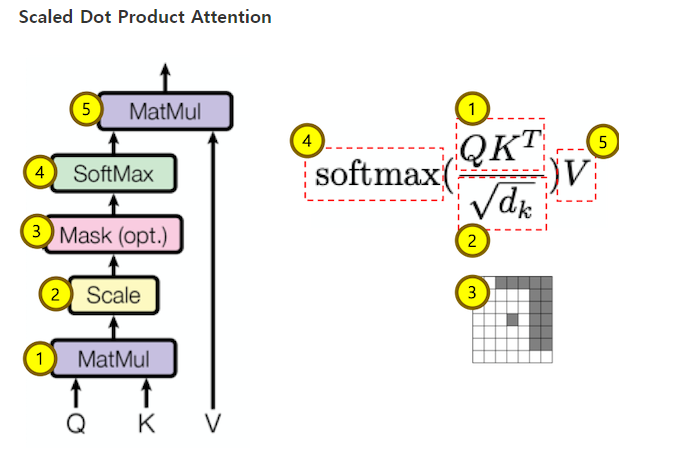

Scaled Dot Product Attention을 구하는 클래스 입니다.

Q * K.transpose를 구합니다. (줄: 11)

K-dimension에 루트를 취한 값으로 나줘 줍니다. (줄: 12)

Mask를 적용 합니다. (줄: 13)

Softmax를 취해 각 단어의 가중치 확률분포 attn_prob를 구합니다. (줄: 15)

attn_prob * V를 구합니다. 구한 값은 Q에 대한 V의 가중치 합 벡터입니다.

In [78]:
""" scale dot product attention """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.dropout = nn.Dropout(config.dropout)
        self.scale = 1 / (self.config.d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2))
        scores = scores.mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores)
        attn_prob = self.dropout(attn_prob)
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V)
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob

## MultiHeadAttention

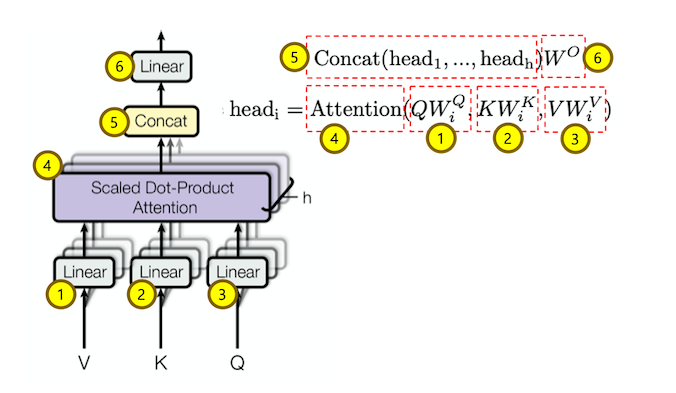

Multi-Head Attention을 구하는 클래스 입니다.

Q * W_Q를 한 후 multi-head로 나눕니다. (줄: 17)

K * W_K를 한 후 multi-head로 나눕니다. (줄: 19)

V * W_V를 한 후 multi-head로 나눕니다. (줄: 21)

ScaledDotProductAttention 클래스를 이용해 각 head별 Attention을 구합니다. (줄: 27)

여러 개의 head를 1개로 합칩니다. (줄: 29)

Linear를 취해 최종 Multi-Head Attention값을 구합니다. (줄: 31)

In [79]:
""" multi head attention """
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.W_Q = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_K = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_V = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(self.config)
        self.linear = nn.Linear(self.config.n_head * self.config.d_head, self.config.d_hidn)
        self.dropout = nn.Dropout(config.dropout)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.config.n_head, 1, 1)
        
        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.config.n_head * self.config.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        output = self.dropout(output)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

## FeedForward

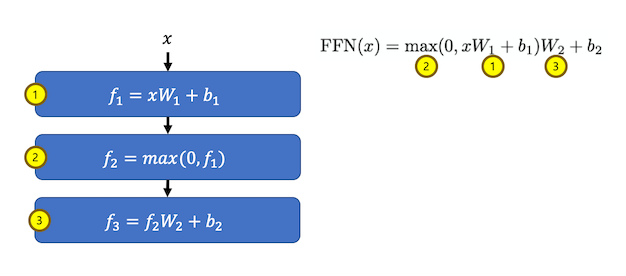

FeeedForward를 처리하는 클래스 입니다.

Linear를 실행하여 shape을 d_ff(hidden * 4) 크기로 키웁니다. (줄: 14)

activation 함수(relu or gelu)를 실행합니다. (줄: 15)

Linear를 실행하여 shape을 hidden 크기로 줄입니다. (줄: 17)

In [80]:
""" feed forward """
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_ff, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.conv1(inputs.transpose(1, 2))
        output = self.active(output)
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        output = self.dropout(output)
        # (bs, n_seq, d_hidn)
        return output

## Encoder Layer

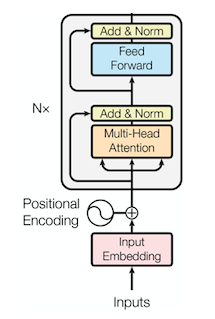

Encoder에서 루프를 돌며 처리 할 수 있도록 EncoderLayer를 정의하고 여러 개 만들어서 실행 합니다.

Multi-Head Attention을 수행합니다. (줄: 14)

Q, K, V 모두 동일한 값을 사용하는 self-attention 입니다.

1번의 결과와 input(residual)을 더한 후 LayerNorm을 실행 합니다. (줄: 15)

2번의 결과를 입력으로 Feed Forward를 실행 합니다. (줄: 17)

3번의 결과와 2번의 결과(residual)을 더한 후 LayerNorm을 실행 합니다. (줄: 18)

In [81]:
""" encoder layer """
class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    
    def forward(self, inputs, attn_mask):
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        att_outputs, attn_prob = self.self_attn(inputs, inputs, inputs, attn_mask)
        att_outputs = self.layer_norm1(inputs + att_outputs)
        # (bs, n_enc_seq, d_hidn)
        ffn_outputs = self.pos_ffn(att_outputs)
        ffn_outputs = self.layer_norm2(ffn_outputs + att_outputs)
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        return ffn_outputs, attn_prob

## Encoder

Encoder 클래스 입니다.

입력에 대한 Position 값을 구합니다. (줄: 14~16)

Input Embedding과 Position Embedding을 구한 후 더합니다. (줄: 19)

입력에 대한 attention pad mask를 구합니다. (줄: 22)

for 루프를 돌며 각 layer를 실행합니다. (줄: 27)

layer의 입력은 이전 layer의 출력 값 입니다.

In [82]:
""" encoder """
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.enc_emb = nn.Embedding(self.config.n_enc_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_enc_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([EncoderLayer(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, inputs):
        positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
        pos_mask = inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)

        # (bs, n_enc_seq, d_hidn)
        outputs = self.enc_emb(inputs) + self.pos_emb(positions)

        # (bs, n_enc_seq, n_enc_seq)
        attn_mask = get_attn_pad_mask(inputs, inputs, self.config.i_pad)

        attn_probs = []
        for layer in self.layers:
            # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
            outputs, attn_prob = layer(outputs, attn_mask)
            attn_probs.append(attn_prob)
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        return outputs, attn_probs

## Decoder Layer

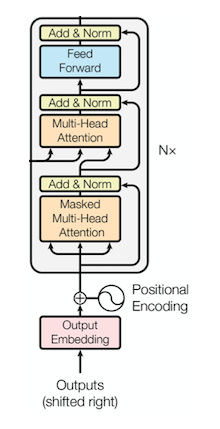

Decoder에서 루프를 돌며 처리 할 수 있도록 DecoderLayer를 정의하고 여러 개 만들어서 실행 합니다.

Multi-Head Attention을 수행합니다. (줄: 16)

Q, K, V 모두 동일한 값을 사용하는 self-attention 입니다.

1번의 결과와 input(residual)을 더한 후 LayerNorm을 실행 합니다. (줄: 17)

Encoder-Decoder Multi-Head Attention을 수행합니다. (줄: 19)

Q: 2번의 결과
K, V: Encoder 결과

3번의 결과와 2번의 결과(residual)을 더한 후 LayerNorm을 실행 합니다. (줄: 20)

4번의 결과를 입력으로 Feed Forward를 실행 합니다. (줄: 22)

5번의 결과와 4번의 결과(residual)을 더한 후 LayerNorm을 실행 합니다. (줄: 23)

In [83]:
""" decoder layer """
class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.dec_enc_attn = MultiHeadAttention(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm3 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    
    def forward(self, dec_inputs, enc_outputs, self_attn_mask, dec_enc_attn_mask):
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq)
        self_att_outputs, self_attn_prob = self.self_attn(dec_inputs, dec_inputs, dec_inputs, self_attn_mask)
        self_att_outputs = self.layer_norm1(dec_inputs + self_att_outputs)
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_enc_seq)
        dec_enc_att_outputs, dec_enc_attn_prob = self.dec_enc_attn(self_att_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_enc_att_outputs = self.layer_norm2(self_att_outputs + dec_enc_att_outputs)
        # (bs, n_dec_seq, d_hidn)
        ffn_outputs = self.pos_ffn(dec_enc_att_outputs)
        ffn_outputs = self.layer_norm3(dec_enc_att_outputs + ffn_outputs)
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq), (bs, n_head, n_dec_seq, n_enc_seq)
        return ffn_outputs, self_attn_prob, dec_enc_attn_prob

## Decoder

Decoder 클래스 입니다.

입력에 대한 Position 값을 구합니다. (줄: 14~16)

Input Embedding과 Position Embedding을 구한 후 더합니다. (줄: 19)

입력에 대한 attention pad mask를 구합니다. (줄: 22)

입력에 대한 decoder attention mask를 구합니다. (줄: 24)

attention pad mask와 decoder attention mask 중 1곳이라도 mask되어 있는 부분인 mask 되도록 attention mask를 구합니다. (줄: 26)

Q(decoder input), K(encoder output)에 대한 attention mask를 구합니다. (줄: 28)

for 루프를 돌며 각 layer를 실행합니다. (줄: 27)

layer의 입력은 이전 layer의 출력 값 입니다.

In [84]:
""" decoder """
class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.dec_emb = nn.Embedding(self.config.n_dec_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_dec_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([DecoderLayer(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        positions = torch.arange(dec_inputs.size(1), device=dec_inputs.device, dtype=dec_inputs.dtype).expand(dec_inputs.size(0), dec_inputs.size(1)).contiguous() + 1
        pos_mask = dec_inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)
    
        # (bs, n_dec_seq, d_hidn)
        dec_outputs = self.dec_emb(dec_inputs) + self.pos_emb(positions)

        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs, self.config.i_pad)
        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_decoder_mask = get_attn_decoder_mask(dec_inputs)
        # (bs, n_dec_seq, n_dec_seq)
        dec_self_attn_mask = torch.gt((dec_attn_pad_mask + dec_attn_decoder_mask), 0)
        # (bs, n_dec_seq, n_enc_seq)
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs, self.config.i_pad)

        self_attn_probs, dec_enc_attn_probs = [], []
        for layer in self.layers:
            # (bs, n_dec_seq, d_hidn), (bs, n_dec_seq, n_dec_seq), (bs, n_dec_seq, n_enc_seq)
            dec_outputs, self_attn_prob, dec_enc_attn_prob = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            self_attn_probs.append(self_attn_prob)
            dec_enc_attn_probs.append(dec_enc_attn_prob)
        # (bs, n_dec_seq, d_hidn), [(bs, n_dec_seq, n_dec_seq)], [(bs, n_dec_seq, n_enc_seq)]S
        return dec_outputs, self_attn_probs, dec_enc_attn_probs

## TransFomer

Transformer 클래스 입니다.

Encoder Input을 입력으로 Encoder를 실행합니다. (줄: 12)

Encoder Output과 Decoder Input을 입력으로 Decoder를 실행합니다. (줄: 14)

In [85]:
""" transformer """
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.encoder = Encoder(self.config)
        self.decoder = Decoder(self.config)
    
    def forward(self, enc_inputs, dec_inputs):
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        enc_outputs, enc_self_attn_probs = self.encoder(enc_inputs)
        # (bs, n_seq, d_hidn), [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        dec_outputs, dec_self_attn_probs, dec_enc_attn_probs = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        # (bs, n_dec_seq, n_dec_vocab), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        return dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs

## Utils

모델 저장 및 로드, metric 저장 및 로드 함수입니다.

In [86]:
""" Functions for saving and loading model parameters and metrics. """
def save_checkpoint(path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}, path)

def load_checkpoint(path, model):    
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    
    return state_dict['valid_loss']

def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):   
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}    
    torch.save(state_dict, path)

def load_metrics(path):    
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

## Naver 영화리뷰 분류 모델 클래스

Encoder input과 Decoder input을 입력으로 Transformer 모델을 실행 합니다. (줄: 12)

Transformer 출력의 max값을 구합니다. (줄: 14)

Linear를 실행하여 최종 예측 결과를 만듭니다. (줄: 16)

In [87]:
""" naver review classfication """
class MovieClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = Transformer(self.config)
        self.projection = nn.Linear(self.config.d_hidn, self.config.n_output, bias=False)
    
    def forward(self, enc_inputs, dec_inputs): 
        # (bs, n_dec_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs = self.transformer(enc_inputs, dec_inputs)
        # (bs, d_hidn)
        dec_outputs, _ = torch.max(dec_outputs, dim=1)
        # (bs, n_output)
        logits = self.projection(dec_outputs)
        # (bs, n_output), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        return logits, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs

## 네이버 영화리뷰 분류 데이터셋

입력 파일로 부터 ‘label’을 읽어 들입니다. (줄: 16)

입력 파일로 부터 ‘doc’ token을 읽어 숫자(token id)로 변경 합니다. (줄: 17)

Decoder 입력은 ‘[BOS]’로 고정 합니다. (줄: 26)

In [88]:
""" 영화 분류 데이터셋 """
class MovieDataSet(torch.utils.data.Dataset):
    def __init__(self, vocab, infile):
        self.vocab = vocab
        self.labels = []
        self.sentences = []

        line_cnt = 0
        with open(infile, "r") as f:
            for line in f:
                line_cnt += 1

        with open(infile, "r") as f:
            for i, line in enumerate(tqdm(f, total=line_cnt, desc=f"Loading {infile}", unit=" lines")):
                data = json.loads(line)
                self.labels.append(data["label"])
                self.sentences.append([vocab.piece_to_id(p) for p in data["doc"]])
    
    def __len__(self):
        assert len(self.labels) == len(self.sentences)
        return len(self.labels)
    
    def __getitem__(self, item):
        return (torch.tensor(self.labels[item]),
                torch.tensor(self.sentences[item]),
                torch.tensor([self.vocab.piece_to_id("[BOS]")]))

## collate_fn
배치단위로 데이터 처리를 위한 collate_fn 함수 입니다.

Encoder inputs의 길이가 같아지도록 짧은 문장에 padding(0)을 추가 합니다. (줄: 5)

padding은 Sentencepiece를 활용해 Vocab 만들기에서 ‘–pad_id=0’옵션으로 지정한 값 입니다.

Decoder inputs의 길이가 같아지도록 짧은 문장에 padding(0)을 추가 합니다. (줄: 6)

Label은 길이가 1 고정이므로 stack 함수를 이용해 tensor로 만듭니다. (줄: 9)

In [89]:
""" movie data collate_fn """
def movie_collate_fn(inputs):
    labels, enc_inputs, dec_inputs = list(zip(*inputs))

    enc_inputs = torch.nn.utils.rnn.pad_sequence(enc_inputs, batch_first=True, padding_value=0)
    dec_inputs = torch.nn.utils.rnn.pad_sequence(dec_inputs, batch_first=True, padding_value=0)

    batch = [
        torch.stack(labels, dim=0),
        enc_inputs,
        dec_inputs,
    ]

    return batch

## DataLoader
위에서 정의한 DataSet과 collate_fn을 이용해 학습용(train_loader), 평가용(test_loader) DataLoader를 만듭니다.

In [90]:
batch_size = 128
train_dataset = MovieDataSet(vocab, "ratings_train.json")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=movie_collate_fn)
test_dataset = MovieDataSet(vocab, "ratings_test.json")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=movie_collate_fn)


Loading ratings_test.json: 100%|██████████| 49997/49997 [00:00<00:00, 50624.45 lines/s]


## Evaluate
학습된 MovieClassification 모델의 성능을 평가하기 위한 함수 입니다. 

평가는 정확도(accuracy)를 사용 했습니다.

Encoder input과 Decoder input을 입력으로 MovieClassification을 실행합니다. (줄: 12)

1번의 결과 중 첫 번째 값이 예측 logits 입니다. (줄: 13)

logits의 최대값의 index를 구합니다. (줄: 14)

3번에게 구한 값과 labels의 값이 같은지 비교 합니다. (줄: 16)

In [91]:
""" 모델 epoch 평가 """
def eval_epoch(config, model, data_loader):
    matchs = []
    model.eval()

    n_word_total = 0
    n_correct_total = 0
    with tqdm(total=len(data_loader), desc=f"Valid") as pbar:
        for i, value in enumerate(data_loader):
            labels, enc_inputs, dec_inputs = map(lambda v: v.to(config.device), value)

            outputs = model(enc_inputs, dec_inputs)
            logits = outputs[0]
            _, indices = logits.max(1)

            match = torch.eq(indices, labels).detach()
            matchs.extend(match.cpu())
            accuracy = np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

            pbar.update(1)
            pbar.set_postfix_str(f"Acc: {accuracy:.3f}")
    return np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

## Train
MovieClassification 모델을 학습하기 위한 함수 입니다.

Encoder input과 Decoder input을 입력으로 MovieClassification을 실행합니다. (줄: 11)

1번의 결과 중 첫 번째 값이 예측 logits 입니다. (줄: 12)

logits 값과 labels의 값을 이용해 Loss를 계산합니다. (줄: 14)

loss, optimizer를 이용해 학습합니다. (줄: 18, 19)


In [92]:
""" 모델 epoch 학습 """
def train_epoch(config, epoch, model, criterion, optimizer, train_loader):
    losses = []
    model.train()

    with tqdm(total=len(train_loader), desc=f"Train {epoch}") as pbar:
        for i, value in enumerate(train_loader):
            labels, enc_inputs, dec_inputs = map(lambda v: v.to(config.device), value)

            optimizer.zero_grad()
            outputs = model(enc_inputs, dec_inputs)
            logits = outputs[0]

            loss = criterion(logits, labels)
            loss_val = loss.item()
            losses.append(loss_val)

            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.3f} ({np.mean(losses):.3f})")
    return np.mean(losses)

학습을 위한 추가적인 내용을 선언 합니다.

GPU 사용 여부를 확인합니다. (줄: 1)

출력 값 개수를 정의 합니다. (부정(0), 긍정(1) 2가지입니다.) (줄: 2)

learning_rate 및 학습 epoch를 선언 합니다. (줄: 5, 6)

In [93]:
config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config.n_output = 2
print(config)

learning_rate = 5e-5
n_epoch = 10

{'n_enc_vocab': 8007, 'n_dec_vocab': 8007, 'n_enc_seq': 256, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12, 'device': device(type='cpu'), 'n_output': 2}


위에서 선언된 내용을 이용해 학습을 실행하는 절차 입니다.

MovieClassification을 생성합니다. (줄: 1)

MovieClassification이 GPU 또는 CPU를 지원하도록 합니다. (줄: 2)

loss 함수를 선언 합니다. (줄: 4)

optimizer를 선언 합니다. (줄: 5)

각 epoch 마다 학습을 합니다. (줄: 9)

각 epoch 마다 평가를 합니다. (줄: 10)

Best Model을 저장 합니다. (줄 : 23)

In [94]:
model = MovieClassification(config)
model.to(config.device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

best_epoch, best_loss, best_score = 0, 0, 0
losses, scores = [], []
for epoch in range(n_epoch):
    loss = train_epoch(config, epoch, model, criterion, optimizer, train_loader)
    score = eval_epoch(config, model, test_loader)

    losses.append(loss)
    scores.append(score)
    
    if best_score < score:
        best_epoch, best_loss, best_score = epoch, loss, score
        save_checkpoint('model.pkl', model, best_loss)
        print("Save Epoch : " , epoch )

print(f">>>> epoch={best_epoch}, loss={best_loss:.5f}, socre={best_score:.5f}")

Train 0:   2%|▏         | 23/1172 [01:05<54:11,  2.83s/it, Loss: 0.692 (0.762)] 


KeyboardInterrupt: 

## 네이버 리뷰 분류 최종 모델 평가 함수

테스트셋에 대한 Classification Report, Confusion Report를 출력합니다.

In [ ]:
# Evaluation Function
def evaluate(config ,model, data_loader):
    y_pred = []
    y_true = []
    matchs = []
    model.eval()

    n_word_total = 0
    n_correct_total = 0
    with tqdm_notebook(total=len(data_loader), desc=f"Valid") as pbar:
        for i, value in enumerate(data_loader):
            labels, enc_inputs, dec_inputs = map(lambda v: v.to(config.device), value)

            outputs = model(enc_inputs, dec_inputs)
            logits = outputs[0]
            _, indices = logits.max(1)
            y_pred.extend(torch.argmax(logits, axis=-1).tolist())
            y_true.extend(labels.tolist())
            
            match = torch.eq(indices, labels).detach()
            matchs.extend(match.cpu())
            accuracy = np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0
            
            pbar.update(1)
            pbar.set_postfix_str(f"Acc: {accuracy:.3f}")

        print('Classification Report:')
        print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax = plt.subplot()

    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['REAL', 'FAKE'])
    ax.yaxis.set_ticklabels(['REAL', 'FAKE'])

    # ROC Curve Plot 그리기
    # fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
    # roc_auc = metrics.auc(fpr, tpr)

    # plt.title('Receiver Operating Characteristic')
    # plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    # plt.legend(loc = 'lower right')
    # plt.plot([0, 1], [0, 1],'r--')
    # plt.xlim([0, 1])
    # plt.ylim([0, 1])
    # plt.ylabel('True Positive Rate')
    # plt.xlabel('False Positive Rate')
    # plt.show()

## 최종 모델 Evaluate

저장된 Best 모델을 로드하여 테스트셋에 대한 Classification Report, Confusion Report를 출력합니다.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


Valid:   0%|          | 0/391 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

           1     0.7973    0.8650    0.8297     25171
           0     0.8502    0.7770    0.8120     24826

    accuracy                         0.8213     49997
   macro avg     0.8237    0.8210    0.8208     49997
weighted avg     0.8236    0.8213    0.8209     49997



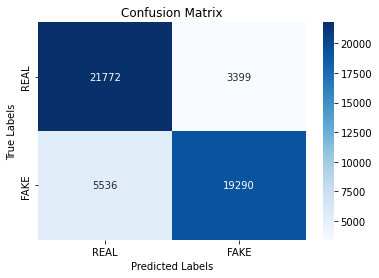

In [ ]:
model = MovieClassification(config)
model.to(config.device)

load_checkpoint('model.pkl', model)
evaluate(config, model, test_loader)

